盛岡 ダート

# preparation

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

#モデル
import lightgbm as lgb

#パラメータ探索
import optuna

#クロスバリデーション
from sklearn.model_selection import KFold

#エヴァリュエーション
from sklearn.metrics import precision_score, recall_score, mean_squared_error

#可視化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

#保存
import pickle

In [2]:
#42, 36, 54, 47, 55

In [3]:
#データを読み込む
j_uma_race_df = pd.read_pickle('../datasets/traindata/j_uma_race.pkl')
j_race_df = pd.read_pickle('../datasets/traindata/j_race.pkl')
# j_payout_df = pd.read_pickle('../datasets/traindata/j_payout.pkl')

n_uma_race_df = pd.read_pickle('../datasets/traindata/n_uma_race.pkl')
n_race_df = pd.read_pickle('../datasets/traindata/n_race.pkl')
n_payout_df = pd.read_pickle('../datasets/traindata/n_payout.pkl')

### データの削除

In [4]:
#浦和競馬場に絞る
pd.set_option('display.max_columns', None)
urayasu_uma_race = n_uma_race_df[n_uma_race_df['keibajo_code'].astype(str) == '35']
urayasu_race = n_race_df[n_race_df['keibajo_code'].astype(str) == '35']
urayasu_uma_race

,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,wakuban,umaban,ketto_toroku_bango,bamei,umakigo_code,seibetsu_code,hinshu_code,moshoku_code,barei,tozai_shozoku_code,chokyoshi_code,banushi_code,banushimei,futan_juryo,blinker_shiyo_kubun,kishu_code,kishumei_ryakusho,kishu_minarai_code,bataiju,zogen_fugo,zogen_sa,ijo_kubun_code,nyusen_juni,kakutei_chakujun,dochaku_kubun,dochaku_tosu,soha_time,chakusa_code_1,chakusa_code_2,chakusa_code_3,corner_1,corner_2,corner_3,corner_4,tansho_odds,tansho_ninkijun,kakutoku_honshokin,kakutoku_fukashokin,kohan_4f,kohan_3f,aiteuma_joho_1,aiteuma_joho_2,aiteuma_joho_3,time_sa,record_koshin_kubun,kyakushitsu_hantei
339,2023,917,35,7,1,1,1,1,2019100705,ステルク,0,1,1.0,3,4,3,20645,946030,大久保 和夫,560.0,0,20424,坂口裕一,0,462.0,2,2.0,0,3,3,0,0,1162,4.0,NaN,NaN,0,0,1,1,37,3,700,0,0,387,2019105880ナイフレスト,0000000000,0000000000,12,0,0
340,2023,917,35,7,1,1,2,2,2019101916,アルバハール,0,1,1.0,1,4,3,20645,0,高橋 清彦,560.0,0,5452,沢田龍哉,0,525.0,0,5.0,0,6,6,0,0,1171,212.0,NaN,NaN,0,0,6,6,379,6,0,0,0,372,2019105880ナイフレスト,0000000000,0000000000,21,0,0
341,2023,917,35,7,1,1,3,3,2019105880,ナイフレスト,0,2,1.0,7,4,3,20723,0,川上 和彦,540.0,0,5552,鈴木祐,0,434.0,2,11.0,0,1,1,0,0,1150,NaN,NaN,NaN,0,0,2,1,20,1,3500,0,0,374,2019102681フィールドグーフィ,0000000000,0000000000,-5,0,0
342,2023,917,35,7,1,1,4,4,2019101120,ハロサン,0,1,1.0,3,4,3,5709,261033,谷 謙介,560.0,0,20401,木村暁,0,443.0,0,1.0,0,4,4,0,0,1166,212.0,NaN,NaN,0,0,5,5,64,4,460,0,0,383,2019105880ナイフレスト,0000000000,0000000000,16,0,0
343,2023,917,35,7,1,1,5,5,2019105732,フレイムリリー,0,2,1.0,4,4,3,20723,0,柴田 茂樹,540.0,0,5560,小林凌,0,444.0,2,9.0,0,5,5,0,0,1167,12.0,NaN,NaN,0,0,3,4,364,5,250,0,0,388,2019105880ナイフレスト,0000000000,0000000000,17,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032170,2023,815,35,6,6,12,4,4,2018100451,ホワイトブライド,0,2,1.0,7,5,3,5481,362800,下河辺牧場,540.0,0,5571,菅原辰徳,0,481.0,2,7.0,0,5,5,0,0,1400,34.0,NaN,NaN,0,0,3,4,105,5,840,0,0,375,2018100116ボウトロイ,0000000000,0000000000,11,0,0
2032171,2023,815,35,6,6,12,5,5,2017103291,グルアーブ,0,2,1.0,3,6,3,20484,854800,ノルマンディーサラブレッドレーシング,540.0,0,5294,村上忍,0,443.0,0,6.0,0,3,3,0,0,1393,212.0,NaN,NaN,0,0,5,3,44,3,2400,0,0,365,2018100116ボウトロイ,0000000000,0000000000,4,0,0
2032172,2023,815,35,6,6,12,6,6,2018100116,ボウトロイ,0,1,1.0,1,5,3,5683,893033,会田 裕一,560.0,0,5299,吉原寛人,0,495.0,0,3.0,0,1,1,0,0,1389,NaN,NaN,NaN,0,0,2,1,65,4,12000,0,0,365,2015105131マイネルアンファン,0000000000,0000000000,0,0,0
2032173,2023,815,35,6,6,12,7,7,2018100039,イディオム,0,1,1.0,1,5,3,5417,457031,佐藤 弘樹,560.0,0,5542,高松亮,0,476.0,0,7.0,0,8,8,0,0,1411,3.0,NaN,NaN,0,0,1,5,437,7,0,0,0,387,2018100116ボウトロイ,0000000000,0000000000,22,0,0


# LightGBM

## グループクエリ用のカラムを作成

In [5]:
# 新しいグループを作成
urayasu_uma_race['group'] = urayasu_uma_race['kaisai_nen'].astype(int).astype(str) +"-"+ urayasu_uma_race['kaisai_tsukihi'].astype(int).astype(str) +"-"+  urayasu_uma_race['keibajo_code'].astype(int).astype(str) +"-"+  urayasu_uma_race['race_bango'].astype(int).astype(str)
urayasu_race['group'] = urayasu_race['kaisai_nen'].astype(int).astype(str) +"-"+ urayasu_race['kaisai_tsukihi'].astype(int).astype(str) +"-"+  urayasu_race['keibajo_code'].astype(int).astype(str) +"-"+  urayasu_race['race_bango'].astype(int).astype(str)
n_payout_df['group'] = n_payout_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_payout_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_payout_df['keibajo_code'].astype(int).astype(str) +"-"+  n_payout_df['race_bango'].astype(int).astype(str)

C:\Users\kawam\AppData\Local\Temp\ipykernel_7940\3114523199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urayasu_uma_race['group'] = urayasu_uma_race['kaisai_nen'].astype(int).astype(str) +"-"+ urayasu_uma_race['kaisai_tsukihi'].astype(int).astype(str) +"-"+  urayasu_uma_race['keibajo_code'].astype(int).astype(str) +"-"+  urayasu_uma_race['race_bango'].astype(int).astype(str)
C:\Users\kawam\AppData\Local\Temp\ipykernel_7940\3114523199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urayasu_race['

In [6]:
urayasu_uma_race['group'].unique()

array(['2023-917-35-1', '2023-917-35-2', '2023-917-35-3', ...,
       '2023-815-35-10', '2023-815-35-11', '2023-815-35-12'], dtype=object)

In [7]:
urayasu_race['group'].unique()

array(['2021-627-35-1', '2021-627-35-2', '2021-627-35-3', ...,
       '2020-1124-35-10', '2020-1124-35-11', '2020-1124-35-12'],
      dtype=object)

In [8]:
urayasu_race = urayasu_race.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango'],axis=1)
n_payout_df = n_payout_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango', 'toroku_tosu', 'shusso_tosu'],axis=1)

In [9]:
merged_df = pd.merge(urayasu_uma_race, urayasu_race, on='group', how='left')
merged_df = pd.merge(merged_df, n_payout_df, on='group', how='left')
merged_df['group'].nunique()

9679

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89897 entries, 0 to 89896
Data columns (total 82 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   kaisai_nen                  89897 non-null  int64  
 1   kaisai_tsukihi              89897 non-null  int64  
 2   keibajo_code                89897 non-null  object 
 3   kaisai_kai                  89897 non-null  int64  
 4   kaisai_nichime              89897 non-null  int64  
 5   race_bango                  89897 non-null  int64  
 6   wakuban                     89897 non-null  int64  
 7   umaban                      89897 non-null  int64  
 8   ketto_toroku_bango          89897 non-null  int64  
 9   bamei                       89897 non-null  object 
 10  umakigo_code                89897 non-null  int64  
 11  seibetsu_code               89897 non-null  int64  
 12  hinshu_code                 89897 non-null  float64
 13  moshoku_code                898

In [11]:
pd.set_option('display.max_columns', None)
merged_df.head(1)

,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,wakuban,umaban,ketto_toroku_bango,bamei,umakigo_code,seibetsu_code,hinshu_code,moshoku_code,barei,tozai_shozoku_code,chokyoshi_code,banushi_code,banushimei,futan_juryo,blinker_shiyo_kubun,kishu_code,kishumei_ryakusho,kishu_minarai_code,bataiju,zogen_fugo,zogen_sa,ijo_kubun_code,nyusen_juni,kakutei_chakujun,dochaku_kubun,dochaku_tosu,soha_time,chakusa_code_1,chakusa_code_2,chakusa_code_3,corner_1,corner_2,corner_3,corner_4,tansho_odds,tansho_ninkijun,kakutoku_honshokin,kakutoku_fukashokin,kohan_4f,kohan_3f,aiteuma_joho_1,aiteuma_joho_2,aiteuma_joho_3,time_sa,record_koshin_kubun,kyakushitsu_hantei,group,yobi_code,jusho_kaiji,grade_code,kyoso_shubetsu_code,kyoso_kigo_code,juryo_shubetsu_code,kyoso_joken_code_2sai,kyoso_joken_code_3sai,kyoso_joken_code_4sai,kyoso_joken_code_5sai_ijo,kyoso_joken_code,kyori,track_code,course_kubun,honshokin,fukashokin,hasso_jikoku,toroku_tosu,shusso_tosu,nyusen_tosu,tenko_code,babajotai_code_shiba,babajotai_code_dirt,fuseiritsu_flag_sanrenpuku,tokubarai_flag_sanrenpuku,henkan_flag_sanrenpuku,haraimodoshi_sanrenpuku_1a,haraimodoshi_sanrenpuku_1b,haraimodoshi_sanrenpuku_1c
0,2023,917,35,7,1,1,1,1,2019100705,ステルク,0,1,1.0,3,4,3,20645,946030,大久保 和夫,560.0,0,20424,坂口裕一,0,462.0,2,2.0,0,3,3,0,0,1162,4.0,NaN,NaN,0,0,1,1,37,3,700,0,0,387,2019105880ナイフレスト,0000000000,0000000000,12,0,0,2023-917-35-1,2,0,0,49,0,0,0,0,0,0,0,1200,23,0,3.500000e+51,0,1225,6,6,6,2,0,2.0,0.0,0.0,0.0,10306.0,180.0,1.0


In [12]:
merged_df['kyori'].value_counts()

kyori
1400    28074
1200    26408
1600    23127
1000     6142
1800     2774
1700     2197
2000      747
2400      404
2500       17
2600        7
Name: count, dtype: int64

In [13]:
merged_df['track_code'].value_counts()
#23:平地　ダート 左回り
#11	平地　芝 　　 左回り	芝・左	Turf

track_code
23    81152
11     8745
Name: count, dtype: int64

In [14]:
merged_df = merged_df[merged_df['track_code'] == 23]

In [15]:
merged_df['grade_code'].value_counts()
# 1	G1（平地競走）
# 2	G2（平地競走）
# 3	G3（平地競走）
# 4	グレードのない重賞
# 5	重賞以外の特別競走
# 6	J･G1（障害競走）
# 7	J･G2（障害競走）
# 8	J･G3（障害競走）
# 0	一般競走　または未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)

grade_code
0    75745
5     4767
3      374
1      266
Name: count, dtype: int64

In [16]:
merged_df['umakigo_code'].value_counts()
# 00	下記以外　または未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)

umakigo_code
0    81152
Name: count, dtype: int64

In [17]:
merged_df['seibetsu_code'].value_counts()
# 0	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	牡馬
# 2	牝馬
# 3	セン馬

seibetsu_code
2    38775
1    37640
3     4737
Name: count, dtype: int64

In [18]:
merged_df['hinshu_code'].value_counts()
# 0	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	サラブレッド	サラ	サラブレッドとして登録したもの。
# 2	サラブレッド系種	サラ系	アラブの血量が２５％未満
# 3	準サラブレッド	準サラ	昭和49年6月1日の登録規定改定により「準サラ」は「サラ系」となり、「準サラ」の品種は廃止された。
# 4	軽半血種	軽半	アングロノルマン、アングロノルマン系種または中半血種と連続2代以上にあたり、軽種を交配したもの。軽半血種相互の交配によって生まれたもの。
# 5	アングロアラブ	アア	アラブの血量が２５％以上（父母の組み合わせにより「アラ系」と異なる。）
# 6	アラブ系種	アラ系	アラブの血量が２５％以上（父母の組み合わせにより「アア」と異なる。）
# 7	アラブ	アラブ	純血のアラブ
# 8	中半血種	中半	異種の中間相互、中半血種の中間相互、の交配で生まれたもの。中半血種と軽種、アングロノルマンとサラブレッドを除く軽種、重半血種と軽種を交配して生まれたもの。

hinshu_code
1.0    80856
2.0      296
Name: count, dtype: int64

In [19]:
merged_df['moshoku_code'].value_counts()
# 00	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 01	栗毛	chestnut	ch.
# 02	栃栗毛	dark chestnut	d.ch.
# 03	鹿毛	bay	b.
# 04	黒鹿毛	dark bay	d.b.
# 05	青鹿毛	brown	br.
# 06	青毛	black	bl.
# 07	芦毛	grey	g.
# 08	栗粕毛		
# 09	鹿粕毛		
# 10	青粕毛		
# 11	白毛	white	w.

moshoku_code
3     35805
1     18938
4     15731
5      5335
7      3845
6      1197
2       289
11       12
Name: count, dtype: int64

In [20]:
merged_df['barei'].value_counts()

barei
3     21384
4     19467
5     13764
6      9046
7      6013
8      3939
2      3445
9      2421
10     1155
11      373
12      111
13       21
14        7
15        6
Name: count, dtype: int64

In [21]:
merged_df['kishu_code'].value_counts()

kishu_code
5490     5352
5294     5280
5445     5121
5542     5007
5571     4296
         ... 
20339       1
1051        1
1077        1
734         1
1032        1
Name: count, Length: 311, dtype: int64

In [22]:
merged_df['chokyoshi_code'].value_counts()

chokyoshi_code
5217     3339
20226    3288
5555     3263
5029     2870
20478    2727
         ... 
20628       1
5612        1
20495       1
1097        1
1009        1
Name: count, Length: 337, dtype: int64

In [23]:
merged_df['banushi_code'].value_counts()

banushi_code
0         41825
815800     4392
261033     2323
826033     1078
612033     1068
          ...  
10033         1
890007        1
837033        1
787800        1
862030        1
Name: count, Length: 858, dtype: int64

In [24]:
merged_df['kishu_minarai_code'].value_counts()
# 0	下記以外　または未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	☆	1Kg減	通算免許期間が3年未満の騎手で勝利数が51回以上100回以下(2004年から) 通算免許期間が3年未満の騎手で勝利数が31回以上100回以下(2003年まで)
# 2	△	2Kg減	通算免許期間が3年未満の騎手で勝利数が31回以上50回以下(2004年から) 通算免許期間が3年未満の騎手で勝利数が21回以上30回以下(2003年まで)
# 3	▲	3Kg減	通算免許期間が3年未満の騎手で勝利数が30回以下(2004年から) 通算免許期間が3年未満の騎手で勝利数が20回以下(2003年まで)

kishu_minarai_code
0    74664
3     2483
2     1812
1     1688
4      505
Name: count, dtype: int64

In [25]:
merged_df['futan_juryo'].value_counts()

futan_juryo
560.0    29840
540.0    28926
550.0     9318
530.0     8553
510.0     1633
520.0     1206
570.0     1098
500.0      375
580.0      184
590.0       12
600.0        3
480.0        2
490.0        2
Name: count, dtype: int64

In [26]:
merged_df['bataiju'].value_counts()

bataiju
462.0    1077
452.0    1056
460.0    1036
455.0    1020
450.0     999
         ... 
347.0       1
581.0       1
343.0       1
350.0       1
592.0       1
Name: count, Length: 258, dtype: int64

In [27]:
merged_df['hutan_wariai'] = merged_df['futan_juryo'] / merged_df['bataiju']

In [28]:
merged_df['zogen_fugo'].value_counts()

zogen_fugo
0    36625
2    35398
1     9129
Name: count, dtype: int64

In [29]:
merged_df['zogen_sa'].value_counts()

zogen_sa
1.0      14031
2.0      12674
3.0      10444
4.0       8614
0.0       7615
5.0       6696
6.0       5152
7.0       3692
8.0       2785
9.0       2009
10.0      1497
11.0      1055
12.0       814
999.0      661
13.0       608
14.0       446
15.0       323
16.0       276
17.0       170
18.0       138
19.0       119
20.0       105
21.0        62
22.0        57
23.0        49
24.0        41
25.0        34
26.0        25
27.0        22
29.0        11
30.0        10
28.0        10
33.0         8
37.0         7
36.0         6
31.0         6
34.0         5
32.0         3
40.0         3
39.0         3
38.0         2
42.0         2
35.0         2
41.0         1
47.0         1
46.0         1
44.0         1
53.0         1
50.0         1
54.0         1
Name: count, dtype: int64

In [30]:
def combine_sign_and_diff(row):
    if row['zogen_fugo'] == 2:
        return row['zogen_sa']
    elif row['zogen_fugo'] == 0:
        return -row['zogen_sa']
    else:
        return 0

merged_df['zogen_ryou'] = merged_df.apply(combine_sign_and_diff, axis=1)

# scaler = MinMaxScaler()
# merged_df['zogen_ryou'] = scaler.fit_transform(merged_df[['zogen_ryou']])

In [31]:
merged_df['ijo_kubun_code'].value_counts()
# 0	下記以外　または未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	出走取消	取消	SCRATCHED	S
# 2	発走除外	発除	EXCLUDED BY STARTERS	ES
# 3	競走除外	競除	EXCLUDED BY STEWARDS	ER
# 4	競走中止	中止	FALL TO FINISH	FF
# 5	失格	失格	DISQUALIFIED	DQ
# 6	落馬再騎乗	再騎	REMOUNT AFTER A CROPPER	RM
# 7	降着	降着	DISQUALIFIED AND PLACED	DQ&P

ijo_kubun_code
0    80299
1      396
3      305
4      149
5        3
Name: count, dtype: int64

In [32]:
merged_df = merged_df[merged_df['ijo_kubun_code'] == 0]

In [33]:
merged_df['kyoso_shubetsu_code'].value_counts()
# 00	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 11	サラブレッド系2歳	サラ２才	サラ系２歳	サラ系２歳	TWO-YEAR-OLDS
# 12	サラブレッド系3歳	サラ３才	サラ系３歳	サラ系３歳	THREE-YEAR-OLDS
# 13	サラブレッド系3歳以上	サラ３上	サラ系３歳上	サラ系３歳以上	THREE-YEAR-OLDS & UP
# 14	サラブレッド系4歳以上	サラ４上	サラ系４歳上	サラ系４歳以上	FOUR-YEAR-OLDS & UP
# 18	サラブレッド系障害3歳以上	障害３上	障害３歳上	サラ障害３歳以上	THREE-YEAR-OLDS & UP STEEPLE-CHASE
# 19	サラブレッド系障害4歳以上	障害４上	障害４歳上	サラ障害４歳以上	FOUR-YEAR-OLDS & UP STEEPLE-CHASE
# 21	アラブ系2歳	アラ２才	アラ系２歳	アラブ系２歳	TWO-YEAR-OLDS ANGLO-ARABS
# 22	アラブ系3歳	アラ３才	アラ系３歳	アラブ系３歳	THREE-YEAR-OLDS ANGLO-ARABS
# 23	アラブ系3歳以上	アラ３上	アラ系３歳上	アラブ系３歳以上	THREE-YEAR-OLDS & UP ANGLO-ARABS
# 24	アラブ系4歳以上	アラ４上	アラ系４歳上	アラブ系４歳以上	FOUR-YEAR-OLDS & UP ANGLO-ARABS

kyoso_shubetsu_code
49    67434
12     8981
11     3395
13      489
Name: count, dtype: int64

In [34]:
j_race_df['kyoso_shubetsu_code'].value_counts()

kyoso_shubetsu_code
12    21794
0     19750
13    18724
14    13839
11    11907
18     1007
19      760
Name: count, dtype: int64

In [35]:
merged_df['kyoso_kigo_code'].value_counts()
# 000	記号なし　または未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 001	(指定)	DSN
# 002	見習騎手 (2003年までの表記)若手騎手 (2004年からの表記)	
# 003	[指定]	DES
# 004	(特指)	SD

kyoso_kigo_code
0    80299
Name: count, dtype: int64

In [36]:
merged_df['juryo_shubetsu_code'].value_counts()
# 0	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	ハンデ	HANDICAP	出走馬の実績等を考慮し、ハンデキャッパーが負担重量を決定するレース
# 2	別定	SPECIAL WEIGHT	レースごとに負担重量を決定する基準が設けられているレース
# 3	馬齢	WEIGHT FOR AGE	馬の年齢や性別によって負担重量を決定するレース
# 4	定量	SPECIAL WEIGHT	別定レースであって、馬の年齢や性別によって負担重量を決定するレース

juryo_shubetsu_code
0    74372
2     3426
4     2096
6      405
Name: count, dtype: int64

In [37]:
merged_df['kyoso_joken_code'].value_counts()
# 000	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 001	１００万円以下	1,000,000 & LESS	収得賞金が100万円以下の馬が出走できる。
# 002	２００万円以下	2,000,000 & LESS	収得賞金が200万円以下の馬が出走できる。
# 003	３００万円以下	3,000,000 & LESS	収得賞金が300万円以下の馬が出走できる。
# 099	９９００万円以下	99,000,000 & LESS	収得賞金が9900万円以下の馬が出走できる。
# 100	１億円以下	100,000,000 & LESS	収得賞金が1億円以下の馬が出走できる。
# 701	新馬	NEWCOMER	サラブレッド系の未出走馬が出走できる。
# 702	未出走	UNRACED	当該競馬以外の競馬(地方競馬または外国の競馬を含む)において、出走したことがなく、当該競馬において、第1着または重賞競走の第2着になったことのない馬が出走できる。
# 703	未勝利	MAIDEN	該当競馬以外の競馬(地方競馬または外国の競馬を含む)において出走し、収得賞金がない馬が出走できる。また未出走馬も出走できる。
# 999	オープン	OPEN	特に記載のない限り、すべての馬が出走できる競走

kyoso_joken_code
0    80299
Name: count, dtype: int64

In [38]:
merged_df['course_kubun'].value_counts()
# 半角2文字　使用するコースを設定
# "A " ～ "E " を設定 尚、2002年以前の東京競馬場は"A1"、"A2"も存在

course_kubun
0    80299
Name: count, dtype: int64

In [39]:
merged_df['shusso_tosu'].value_counts()

shusso_tosu
10    25801
9     18853
8     12949
11     7157
7      6380
12     5661
6      1719
14      558
0       497
5       310
13      194
16      144
15       60
4        16
Name: count, dtype: int64

In [40]:
merged_df['tenko_code'].value_counts()
# 0	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	晴	Fine
# 2	曇	Cloudy
# 3	雨	Rainy
# 4	小雨	Drizzle
# 5	雪	Snow
# 6	小雪	Light Snow

tenko_code
2    37075
1    32907
4     6060
3     3769
0      428
6       60
Name: count, dtype: int64

In [41]:
merged_df['babajotai_code_shiba'].value_counts()

babajotai_code_shiba
0    80299
Name: count, dtype: int64

In [42]:
merged_df['babajotai_code_dirt'].value_counts()
# 0	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	良	Firm	Standard
# 2	稍重	Good	Good
# 3	重	Yielding	Muddy
# 4	不良	Soft	Sloppy

babajotai_code_dirt
1.0    50721
2.0    12937
4.0     8764
3.0     7449
0.0      428
Name: count, dtype: int64

In [43]:
merged_df['haraimodoshi_sanrenpuku_1b'].value_counts()

haraimodoshi_sanrenpuku_1b
520.0      493
310.0      484
410.0      465
330.0      455
500.0      444
          ... 
15330.0      7
32060.0      7
20670.0      7
10820.0      7
8420.0       6
Name: count, Length: 1678, dtype: int64

## LightGBM

### テスト用と学習用のデータに分け、モデルを作成

In [44]:
# 2010年から2019年のデータを学習データとして取得
train_data = merged_df[merged_df['kaisai_nen'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

# ランキング学習のために必要な特徴量とターゲットを設定
features = [
            'kyori',
            'grade_code',
            'seibetsu_code',
            'moshoku_code',
            'barei',
            'chokyoshi_code',
            'banushi_code',
            'kishu_code',
            'kishu_minarai_code',
            'kyoso_shubetsu_code',
            'juryo_shubetsu_code',
            'shusso_tosu',
            'tenko_code',
            'babajotai_code_dirt',
            'hutan_wariai',
            'zogen_ryou',
            ]

target = 'kakutei_chakujun'

# LightGBM用のデータセットを作成
train_dataset = lgb.Dataset(train_data[features], label=train_data[target])

def objective(trial):
    # Optunaで調整するパラメータを設定
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
    }
    
    # k=5のFOLDでデータを分割
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # 各FOLDでの評価値を保存するためのリスト
    rmses = []
    
    # LightGBMモデルを訓練
    for train_index, valid_index in kf.split(train_data):
        train_fold_data = train_data.iloc[train_index]
        valid_fold_data = train_data.iloc[valid_index]
        
        train_dataset = lgb.Dataset(train_fold_data[features], label=train_fold_data[target])
        valid_dataset = lgb.Dataset(valid_fold_data[features], label=valid_fold_data[target])
        
        model = lgb.train(params, train_dataset, num_boost_round=1000, valid_sets=[valid_dataset], early_stopping_rounds=100, verbose_eval=100)
        
        # RMSEを計算して保存
        y_pred = model.predict(valid_fold_data[features])
        rmse = np.sqrt(mean_squared_error(valid_fold_data[target], y_pred))
        rmses.append(rmse)
    
    # 5-FOLDの平均RMSEを返す
    return np.mean(rmses)

# Optunaでのパラメータ探索を実行
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# 最適なパラメータ
best_params = study.best_params
best_params['metric'] = 'rmse'  # ここでmetricを追加

# KFoldでのモデル訓練
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []

for train_index, valid_index in kf.split(train_data):
    train_fold_data = train_data.iloc[train_index]
    valid_fold_data = train_data.iloc[valid_index]
    
    train_dataset = lgb.Dataset(train_fold_data[features], label=train_fold_data[target])
    valid_dataset = lgb.Dataset(valid_fold_data[features], label=valid_fold_data[target])
    
    model = lgb.train(best_params, train_dataset, num_boost_round=500, valid_sets=[valid_dataset], early_stopping_rounds=20, verbose_eval=100)  # ここでearly_stopping_roundsを50に変更
    models.append(model)

[I 2023-10-09 11:06:50,197] A new study created in memory with name: no-name-ba12ea92-beb3-4ccc-b390-e3e1cca60d5e


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 45523, number of used features: 16
[LightGBM] [Info] Start training from score 5.116952
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.78683
[200]	valid_0's rmse: 2.77259
[300]	valid_0's rmse: 2.75906
[400]	valid_0's rmse: 2.74662
[500]	valid_0's rmse: 2.73418
[600]	valid_0's rmse: 2.7231
[700]	valid_0's rmse: 2.71265
[800]	valid_0's rmse: 2.70312
[900]	valid_0's rmse: 2.69388
[1000]	valid_0's rmse: 2.68522
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.68522
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002060 seconds.
You can set `force_row_wise=true` to remove 

[I 2023-10-09 11:07:22,006] Trial 0 finished with value: 2.6904531333993935 and parameters: {'num_leaves': 54, 'learning_rate': 0.0006032221791361226, 'feature_fraction': 0.5228341409003399}. Best is trial 0 with value: 2.6904531333993935.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 45523, number of used features: 16
[LightGBM] [Info] Start training from score 5.116952
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.51413
[200]	valid_0's rmse: 2.48355
[300]	valid_0's rmse: 2.47462
[400]	valid_0's rmse: 2.47003
[500]	valid_0's rmse: 2.46736
[600]	valid_0's rmse: 2.46411
[700]	valid_0's rmse: 2.46285
Early stopping, best iteration is:
[681]	valid_0's rmse: 2.46224
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2023-10-09 11:07:48,556] Trial 1 finished with value: 2.482407509770677 and parameters: {'num_leaves': 112, 'learning_rate': 0.03798829238690352, 'feature_fraction': 0.8439478245506459}. Best is trial 1 with value: 2.482407509770677.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 45523, number of used features: 16
[LightGBM] [Info] Start training from score 5.116952
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.54752
[200]	valid_0's rmse: 2.50707
[300]	valid_0's rmse: 2.49047
[400]	valid_0's rmse: 2.48185
[500]	valid_0's rmse: 2.47699
[600]	valid_0's rmse: 2.47371
[700]	valid_0's rmse: 2.47024
[800]	valid_0's rmse: 2.4685
[900]	valid_0's rmse: 2.46583
[1000]	valid_0's rmse: 2.46468
Did not meet early stopping. Best iteration is:
[961]	valid_0's rmse: 2.4645
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002894 seconds.
You can set `force_row_wise=true` to remove th

[I 2023-10-09 11:08:38,975] Trial 2 finished with value: 2.4770365686101017 and parameters: {'num_leaves': 128, 'learning_rate': 0.02265702627111241, 'feature_fraction': 0.589685327273332}. Best is trial 2 with value: 2.4770365686101017.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 45523, number of used features: 16
[LightGBM] [Info] Start training from score 5.116952
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.50583
[200]	valid_0's rmse: 2.49177
[300]	valid_0's rmse: 2.48398
[400]	valid_0's rmse: 2.48025
[500]	valid_0's rmse: 2.47825
[600]	valid_0's rmse: 2.47765
Early stopping, best iteration is:
[599]	valid_0's rmse: 2.47761
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Numbe

[I 2023-10-09 11:08:54,213] Trial 3 finished with value: 2.491688875074587 and parameters: {'num_leaves': 45, 'learning_rate': 0.08549760423395317, 'feature_fraction': 0.913068871397095}. Best is trial 2 with value: 2.4770365686101017.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 45523, number of used features: 16
[LightGBM] [Info] Start training from score 5.116952
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.66168
[200]	valid_0's rmse: 2.59125
[300]	valid_0's rmse: 2.55062
[400]	valid_0's rmse: 2.52581
[500]	valid_0's rmse: 2.5096
[600]	valid_0's rmse: 2.49942
[700]	valid_0's rmse: 2.49135
[800]	valid_0's rmse: 2.48603
[900]	valid_0's rmse: 2.48112
[1000]	valid_0's rmse: 2.47735
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.47735
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002782 seconds.
You can set `force_row_wise=true` to remove 

[I 2023-10-09 11:10:20,030] Trial 4 finished with value: 2.4887768944783915 and parameters: {'num_leaves': 254, 'learning_rate': 0.006723256327793673, 'feature_fraction': 0.4234830877778213}. Best is trial 2 with value: 2.4770365686101017.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 45523, number of used features: 16
[LightGBM] [Info] Start training from score 5.116952
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.76073
[200]	valid_0's rmse: 2.72559
[300]	valid_0's rmse: 2.69656
[400]	valid_0's rmse: 2.6723
[500]	valid_0's rmse: 2.65129
[600]	valid_0's rmse: 2.63337
[700]	valid_0's rmse: 2.61823
[800]	valid_0's rmse: 2.60542
[900]	valid_0's rmse: 2.59416
[1000]	valid_0's rmse: 2.58473
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.58473
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002606 seconds.
You can set `force_row_wise=true` to remove 

[I 2023-10-09 11:11:14,312] Trial 5 finished with value: 2.59286410535769 and parameters: {'num_leaves': 118, 'learning_rate': 0.0013329132555376462, 'feature_fraction': 0.6909242597351588}. Best is trial 2 with value: 2.4770365686101017.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 45523, number of used features: 16
[LightGBM] [Info] Start training from score 5.116952
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.63567
[200]	valid_0's rmse: 2.58149
[300]	valid_0's rmse: 2.55467
[400]	valid_0's rmse: 2.53717
[500]	valid_0's rmse: 2.52514
[600]	valid_0's rmse: 2.5164
[700]	valid_0's rmse: 2.51056
[800]	valid_0's rmse: 2.50646
[900]	valid_0's rmse: 2.50251
[1000]	valid_0's rmse: 2.49897
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.49897
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002451 seconds.
You can set `force_row_wise=true` to remove 

[I 2023-10-09 11:11:40,672] Trial 6 finished with value: 2.512298055327372 and parameters: {'num_leaves': 58, 'learning_rate': 0.008357525777627715, 'feature_fraction': 0.9371472761676047}. Best is trial 2 with value: 2.4770365686101017.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 45523, number of used features: 16
[LightGBM] [Info] Start training from score 5.116952
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.79556
[200]	valid_0's rmse: 2.78857
[300]	valid_0's rmse: 2.78195
[400]	valid_0's rmse: 2.77578
[500]	valid_0's rmse: 2.76976
[600]	valid_0's rmse: 2.76392
[700]	valid_0's rmse: 2.75837
[800]	valid_0's rmse: 2.75294
[900]	valid_0's rmse: 2.7477
[1000]	valid_0's rmse: 2.74278
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.74278
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_row_wise=true` to remove 

[I 2023-10-09 11:11:55,860] Trial 7 finished with value: 2.746961467386277 and parameters: {'num_leaves': 14, 'learning_rate': 0.00028756417465272303, 'feature_fraction': 0.7408423677031439}. Best is trial 2 with value: 2.4770365686101017.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 45523, number of used features: 16
[LightGBM] [Info] Start training from score 5.116952
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.49522
[200]	valid_0's rmse: 2.48196
[300]	valid_0's rmse: 2.4768
[400]	valid_0's rmse: 2.4745
[500]	valid_0's rmse: 2.47738
Early stopping, best iteration is:
[405]	valid_0's rmse: 2.47383
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train se

[I 2023-10-09 11:12:13,117] Trial 8 finished with value: 2.4856436104791233 and parameters: {'num_leaves': 84, 'learning_rate': 0.09843802331382931, 'feature_fraction': 0.6047335956110573}. Best is trial 2 with value: 2.4770365686101017.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 45523, number of used features: 16
[LightGBM] [Info] Start training from score 5.116952
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.75032
[200]	valid_0's rmse: 2.70841
[300]	valid_0's rmse: 2.67498
[400]	valid_0's rmse: 2.64841
[500]	valid_0's rmse: 2.62625
[600]	valid_0's rmse: 2.60821
[700]	valid_0's rmse: 2.59344
[800]	valid_0's rmse: 2.58133
[900]	valid_0's rmse: 2.5708
[1000]	valid_0's rmse: 2.56203
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.56203
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove 

[I 2023-10-09 11:13:04,759] Trial 9 finished with value: 2.5710188927875484 and parameters: {'num_leaves': 116, 'learning_rate': 0.0017952979985881876, 'feature_fraction': 0.6530829318827802}. Best is trial 2 with value: 2.4770365686101017.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 45523, number of used features: 16
[LightGBM] [Info] Start training from score 5.116952
Training until validation scores don't improve for 20 rounds
[100]	valid_0's rmse: 2.54752
[200]	valid_0's rmse: 2.50707
[300]	valid_0's rmse: 2.49047
[400]	valid_0's rmse: 2.48185
[500]	valid_0's rmse: 2.47699
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 2.47699
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points i

### テストデータで予測

In [45]:
# 2020年から2022年のテストデータを取得
test_data_2020 = merged_df[merged_df['kaisai_nen'] == 2020].copy()
test_data_2021 = merged_df[merged_df['kaisai_nen'] == 2021].copy()
test_data_2022 = merged_df[merged_df['kaisai_nen'] == 2022].copy()

# 2021年と2022年のデータに対して予測を行い、平均を取る
test_data_2020.loc[:, 'y_pred'] = sum([model.predict(test_data_2020[features], num_iteration=model.best_iteration) for model in models]) / len(models)
test_data_2021.loc[:, 'y_pred'] = sum([model.predict(test_data_2021[features], num_iteration=model.best_iteration) for model in models]) / len(models)
test_data_2022.loc[:, 'y_pred'] = sum([model.predict(test_data_2022[features], num_iteration=model.best_iteration) for model in models]) / len(models)

# 予測されたランクをグループごとに計算
test_data_2020.loc[:, 'predicted_rank'] = test_data_2020.groupby('group')['y_pred'].rank(method='min')
test_data_2021.loc[:, 'predicted_rank'] = test_data_2021.groupby('group')['y_pred'].rank(method='min')
test_data_2022.loc[:, 'predicted_rank'] = test_data_2022.groupby('group')['y_pred'].rank(method='min')

# 結果を表示
test_data_2021[['group', 'predicted_rank', 'kakutei_chakujun']]

,group,predicted_rank,kakutei_chakujun
71602,2021-627-35-1,8.0,1
71603,2021-627-35-1,5.0,2
71604,2021-627-35-1,4.0,8
71605,2021-627-35-1,6.0,4
71606,2021-627-35-1,2.0,7
...,...,...,...
78689,2021-1123-35-12,4.0,2
78690,2021-1123-35-12,3.0,3
78691,2021-1123-35-12,7.0,4
78692,2021-1123-35-12,6.0,9


## モデル評価

In [46]:
# RMSEを計算
rmse_2020 = np.sqrt(mean_squared_error(test_data_2020['predicted_rank'], test_data_2020['kakutei_chakujun']))
print(f"2021 RMSE: {rmse_2020:.3%}")
rmse_2021 = np.sqrt(mean_squared_error(test_data_2021['predicted_rank'], test_data_2021['kakutei_chakujun']))
print(f"2021 RMSE: {rmse_2021:.3%}")
rmse_2022 = np.sqrt(mean_squared_error(test_data_2022['predicted_rank'], test_data_2022['kakutei_chakujun']))
print(f"2022 RMSE: {rmse_2022:.3%}")
rmse_mean = np.mean([rmse_2020, rmse_2021, rmse_2022])
print(f"Mean RMSE: {rmse_mean:.3%}")

2021 RMSE: 326.610%
2021 RMSE: 341.748%
2022 RMSE: 342.078%
Mean RMSE: 336.812%


In [47]:
group_ids_2020 = test_data_2020['group'].unique()
precisions = []
recalls = []

In [48]:
def precision_at_5(predictions, actual):
    top_5_predictions = predictions.argsort()[-5:][::-1]  # 予測の上位5頭のインデックス
    top_3_actual = actual.argsort()[-3:][::-1]  # 実際の上位3頭のインデックス
    common_elements = np.intersect1d(top_5_predictions, top_3_actual)  # 共通の要素を抽出
    precision = len(common_elements) / 5
    return precision

def recall_at_5(predictions, actual):
    top_5_predictions = predictions.argsort()[-5:][::-1]  # 予測の上位5頭のインデックス
    top_3_actual = actual.argsort()[-3:][::-1]  # 実際の上位3頭のインデックス
    common_elements = np.intersect1d(top_5_predictions, top_3_actual)  # 共通の要素を抽出
    recall = len(common_elements) / 3
    return recall

In [49]:
def check_top3_in_top5_predictions(group):
    predicted_top5 = group.nsmallest(5, 'y_pred').index.tolist()
    actual_top3 = group.nsmallest(3, 'kakutei_chakujun').index.tolist()
    return all([horse in predicted_top5 for horse in actual_top3])

def calculate_group_profit(group):
    if check_top3_in_top5_predictions(group):
        payout_value = group['haraimodoshi_sanrenpuku_1b'].iloc[0]
        return payout_value - 1000
    else:
        return -1000

In [50]:
for test_data in [test_data_2020, test_data_2021, test_data_2022]:
    merged_data = test_data
    profits = merged_data.groupby('group').apply(calculate_group_profit).reset_index()
    profits.columns = ['group', 'profit']
    test_data = pd.merge(test_data, profits, on='group', how='left')

for group_id in group_ids_2020:
    test_data = test_data_2020[test_data_2020['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2020 = np.mean(precisions)
recall_5_2020 = np.mean(recalls)

print(f"2020 Precision@5: {precision_5_2020:.3%}")
print(f"2020 Recall@5: {recall_5_2020:.3%}")

group_ids_2021 = test_data_2021['group'].unique()
precisions = []
recalls = []

2020 Precision@5: 41.775%
2020 Recall@5: 69.624%


In [51]:
for group_id in group_ids_2021:
    test_data = test_data_2021[test_data_2021['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2021 = np.mean(precisions)
recall_5_2021 = np.mean(recalls)

print(f"2021 Precision@5: {precision_5_2021:.3%}")
print(f"2021 Recall@5: {recall_5_2021:.3%}")


roup_ids_2022 = test_data_2022['group'].unique()
precisions = []
recalls = []

for group_id in roup_ids_2022:
    test_data = test_data_2022[test_data_2022['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2022 = np.mean(precisions)
recall_5_2022 = np.mean(recalls)

print(f"2022 Precision@5: {precision_5_2022:.3%}")
print(f"2022 Recall@5: {recall_5_2022:.3%}")


precision_5_mean = np.mean([precision_5_2020, precision_5_2021, precision_5_2022])
recall_5_mean = np.mean([recall_5_2020, recall_5_2021, recall_5_2022])

print(f"Mean Precision@5: {precision_5_mean:.3%}")
print(f"Mean Recall@5: {recall_5_mean:.3%}")

# 各レースで上記の関数を適用
results_2020 = test_data_2020.groupby('group').apply(check_top3_in_top5_predictions)
results_2021 = test_data_2021.groupby('group').apply(check_top3_in_top5_predictions)
results_2022 = test_data_2022.groupby('group').apply(check_top3_in_top5_predictions)

# 予測モデルが成功したレースのインデックスを取得する
successful_groups_2020 = results_2020[results_2020].index
successful_groups_2021 = results_2021[results_2021].index
successful_groups_2022 = results_2022[results_2022].index

# そのインデックスを使用して、harai_dfから対応する支払倍率を取得する
successful_payout_2020 = merged_df[merged_df['group'].isin(successful_groups_2020)]
successful_payout_2021 = merged_df[merged_df['group'].isin(successful_groups_2021)]
successful_payout_2022 = merged_df[merged_df['group'].isin(successful_groups_2022)]

payouts_2020 = successful_payout_2020['haraimodoshi_sanrenpuku_1b']
payouts_2021 = successful_payout_2021['haraimodoshi_sanrenpuku_1b']
payouts_2022 = successful_payout_2022['haraimodoshi_sanrenpuku_1b']

# すべての成功したレースに対して、100円をかけた場合の支払いを計算する
total_payout_2020 = (payouts_2020).sum()
total_payout_2021 = (payouts_2021).sum()
total_payout_2022 = (payouts_2022).sum()

# 合計の支払いから、すべてのレースにかけた合計金額を引くことで、純利益を計算する
total_investment_2020 = test_data_2020['group'].nunique() * 1000
total_investment_2021 = test_data_2021['group'].nunique() * 1000
total_investment_2022 = test_data_2021['group'].nunique() * 1000

net_profit_2020 = total_payout_2020 - total_investment_2020
net_profit_2021 = total_payout_2021 - total_investment_2021
net_profit_2022 = total_payout_2022 - total_investment_2022

average_net_profit_2020 = net_profit_2020/len(test_data_2020)
average_net_profit_2021 = net_profit_2021/len(test_data_2021)
average_net_profit_2022 = net_profit_2020/len(test_data_2022)

print(f"2020 Average Net Profit: {average_net_profit_2020:.3f} yen")
print(f"2021 Average Net Profit: {average_net_profit_2021:.3f} yen")
print(f"2022 Average Net Profit: {average_net_profit_2022:.3f} yen")

mean_average_net_profit = np.mean([average_net_profit_2020, average_net_profit_2021, average_net_profit_2022])
print(f"Mean Average Net Profit: {mean_average_net_profit:.3f} yen")

2021 Precision@5: 39.769%
2021 Recall@5: 66.282%
2022 Precision@5: 39.888%
2022 Recall@5: 66.480%
Mean Precision@5: 40.477%
Mean Recall@5: 67.462%
2020 Average Net Profit: 505.456 yen
2021 Average Net Profit: 434.473 yen
2022 Average Net Profit: 493.298 yen
Mean Average Net Profit: 477.742 yen


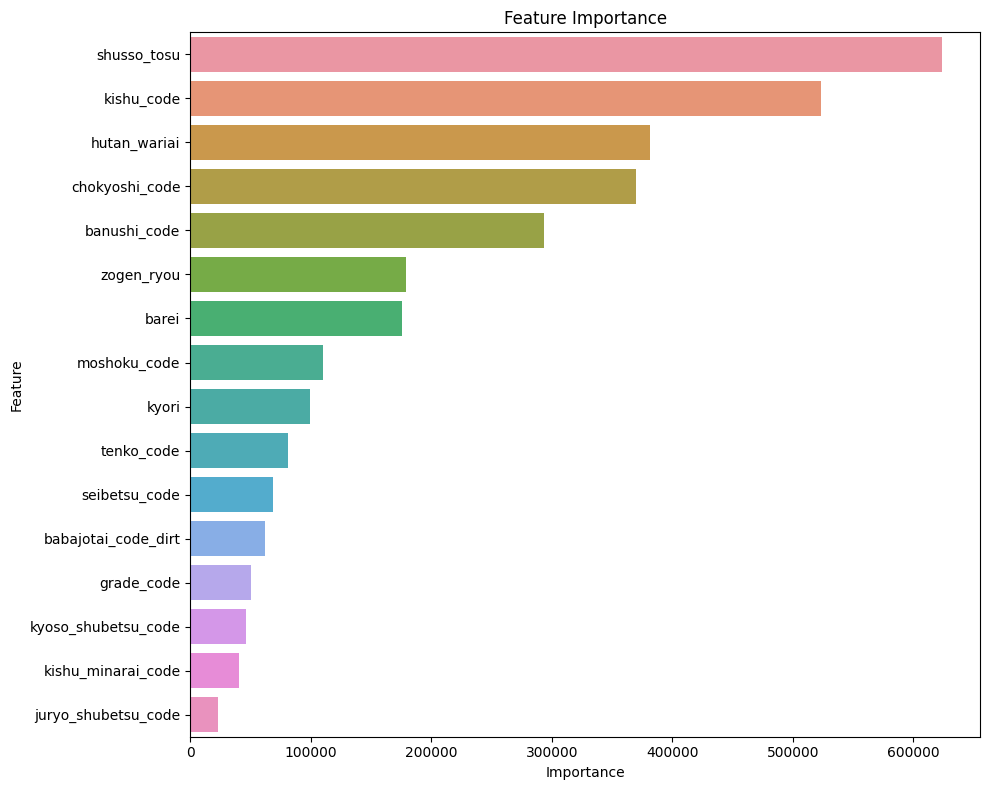

In [52]:
# models[0]の特徴量の重要度を取得
feature_importance = models[0].feature_importance(importance_type='gain')

# 特徴量の名前と重要度をDataFrameに変換
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# 重要度の降順にソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# プロット
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [53]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 1. 箱ひげ図
# for feature in features:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x='kyakushitsu_hantei', y=feature, data=test_data_2020)
#     plt.title(f'Box plot of {feature} by label')
#     plt.show()

# # 2. バイオリンプロット
# for feature in features:
#     plt.figure(figsize=(10, 6))
#     sns.violinplot(x='kyakushitsu_hantei', y=feature, data=test_data_2020)
#     plt.title(f'Violin plot of {feature} by label')
#     plt.show()

# # 3. ペアプロット (特徴量が多すぎる場合は時間がかかる可能性があるので注意)
# sns.pairplot(test_data_2020, hue='kyakushitsu_hantei', vars=features)
# plt.show()

# モデル保存

In [54]:
# 学習
full_train_dataset = lgb.Dataset(merged_df[features], label=merged_df[target])
full_model = lgb.train(best_params, full_train_dataset, num_boost_round=500, verbose_eval=100)  # ここではvalid_setsやearly_stopping_roundsは使用しない

# モデルを保存
model_save_path = 'bestmodels/morioka.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump(full_model, f)

print(f"Model saved to {model_save_path}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 80299, number of used features: 16
[LightGBM] [Info] Start training from score 5.145905
Model saved to bestmodels/morioka.pkl
